In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os

In [3]:
# 1. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

Training on device: cpu


In [4]:
# 2. Train Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# 3. Dataset
dataset_path = './dataset/train' # <--- แก้ไข path ตรงนี้
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

In [6]:
# 4. Train-Validation Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# 5. Build Model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

In [8]:
# 6. Freeze Pre-trained Layers
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.last_channel, 2)
model = model.to(device)

In [9]:
# 7. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [10]:
# 8. Train the Model
epochs = 5
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Loss 
        running_loss += loss.item() * images.size(0)
        
        # Train Accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    
    # Statistic
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}%")
    print(f"Val Loss: {epoch_val_loss:.4f}   | Val Acc: {epoch_val_acc*100:.2f}%")
    print("-" * 40)

Epoch 1/5
Train Loss: 0.5421 | Train Acc: 72.46%
Val Loss: 0.4294   | Val Acc: 84.59%
----------------------------------------
Epoch 2/5
Train Loss: 0.4078 | Train Acc: 82.71%
Val Loss: 0.3511   | Val Acc: 87.97%
----------------------------------------
Epoch 3/5
Train Loss: 0.3584 | Train Acc: 84.77%
Val Loss: 0.3271   | Val Acc: 90.98%
----------------------------------------
Epoch 4/5
Train Loss: 0.3329 | Train Acc: 87.88%
Val Loss: 0.3113   | Val Acc: 88.35%
----------------------------------------
Epoch 5/5
Train Loss: 0.3021 | Train Acc: 88.72%
Val Loss: 0.3015   | Val Acc: 87.97%
----------------------------------------


In [ ]:
# 9. Save the Model
torch.save(model.state_dict(), 'men_women_mobilenet.pth')
print("Model saved as 'men_women_mobilenet.pth'")

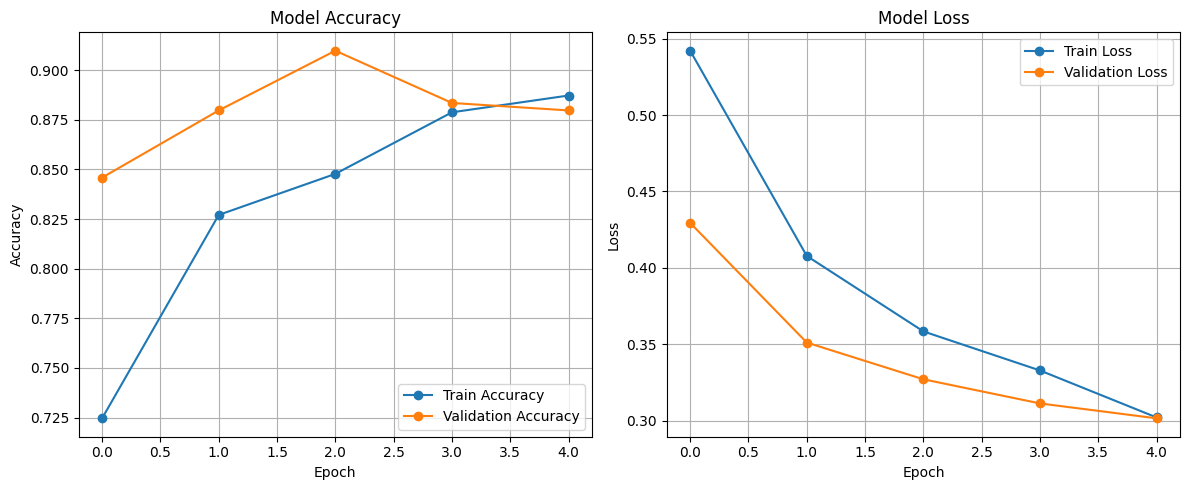

In [12]:
# 10. Visualize Training History
plt.figure(figsize=(12, 5))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()